## 02: Data Preparation

1. Here we construct our dataset for use in the experiment.

In [2]:
# import required libraries
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import random
import libs.utils as utils
import libs.bounding_box as bounding_box
import libs.patch_tools as patch_tools
import libs.data_prep as data_prep
import libs.train_test_split as tts
import libs.importing as importing
import libs.render as render
import libs.stats as stats
import libs.patch_tools as patch_tools
from importlib import reload


# set the random seed for we always get the same results (for now)
random.seed(42)


In [3]:
# GENERATE DATASET ID
exp_id = utils.short_id()
# use same data
exp_id = '41157150'
print('ID: {}'.format(exp_id))

ID: 41157150


In [4]:
# COPY DATA and SETUP EXPERIMENT
base_dir = '../source_dataset/good_v1'
data_prep.setup_experiment(base_dir, exp_id)

In [15]:
# 2-CLASS PROBLEM : Benign v. Papilloma

# SETUP : GET ALL CONTOURS
roi_df = pd.read_csv(os.path.join(exp_id, 'contours.csv'))
roi_2class = roi_df.copy()

# SELECT : only benign and papilloma labeled contours
roi_2class = roi_2class[roi_2class.label.isin([1,3,4])].reset_index(drop=True)

# combine all dysplasias and carcinomas
roi_2class.loc[roi_2class['label'] == 4, 'label'] = 3
roi_2class.loc[roi_2class['label'] == 3, 'label'] = 2

train2bp_df, test2bp_df, val2bp_df = tts.train_test_validation_split(roi_2class, classes=[1,2], samples=3)

# SAVE : save the results
train2bp_df.to_csv(os.path.join(exp_id, 'contours_train.csv'), index=False)
test2bp_df.to_csv(os.path.join(exp_id, 'contours_test.csv'), index=False)
val2bp_df.to_csv(os.path.join(exp_id, 'contours_val.csv'), index=False)

n: 54
distribution: [1 2] [21 33]
classes: [1 2], samples_per_class: 3
train-n: 42
test-n: 6
val-n: 6


In [3]:
# OR IF we've already run this notebook before we can just load the data
train2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
test2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
val2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))

In [16]:
# LOG : show all the contours we dumped and those we are using
#       these are logged at: 
#       [dumped] ./exp_id/log/eleminated_contours
#       [kept]   ./exp_id/log/experiment_contours
data_prep.show_contours_for_experiment(exp_id, roi_df, roi_2class)

total contours: 65
eliminated contours: 11
kept contours: 54


image_id        id          name  label
0   hgv-2d4a6a46  2a8db1fa  2a8db1fa.csv      2
1   hgv-8528141b  a58c9552  a58c9552.csv      2
2   hgv-8528141b  0f887b7a  0f887b7a.csv      2
3   hgv-99fc12a1  b257c7ff  b257c7ff.csv      2
4   hgv-99fc12a1  145037c7  145037c7.csv      2
5   hgv-99fc12a1  51b064d6  51b064d6.csv      2
6   hgv-99fc12a1  93d2c382  93d2c382.csv      2
7   hgv-2cdb69f6  935831de  935831de.csv      2
8   hgv-2cdb69f6  182410a0  182410a0.csv      2
9   hgv-2cdb69f6  2b225cd3  2b225cd3.csv      2
10  hgv-ff91c0a9  1642ec96  1642ec96.csv      2

In [17]:
# TRAIN : data setup
#       : creates a directory ./exp_id/train/  where all the images and contours for training are stored
#       : creates a directory ./exp_id/train/log/info, where the contours and labels for the training set are stored as images for debugging purposes. 
train_df  = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
data_prep.setup_component(exp_id, train_df, 'train')
data_prep.log_component_info(os.path.join(exp_id, 'train'))

In [18]:
# TEST : data setup
#       : creates a directory ./exp_id/test/  where all the images and contours for test data are stored
#       : creates a directory ./exp_id/test/log/info, where the contours and labels for the test set are stored as images for debugging purposes.
test_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
data_prep.setup_component(exp_id, test_df, 'test')
data_prep.log_component_info(os.path.join(exp_id, 'test'))

In [19]:
# VALIDATION : data setup
#       : creates a directory ./exp_id/val/  where all the images and contours for validation data are stored
#       : creates a directory ./exp_id/val/log/info, where the contours and labels for the validation set are stored as images for debugging purposes.
val_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))
data_prep.setup_component(exp_id, val_df, 'val')
data_prep.log_component_info(os.path.join(exp_id, 'val'))

In [20]:
# GENERATE PATCHES : training data
#                    logs information to ./exp_id/train/log/setup_patches, where it shows patches on the image before and after removal

# threshold : the percentage a patch needs to overlap with the contour polygon in order to not be discarded
# patch_overlap : the shift size, should be a value which generates a factor of 64 for instance 0.5*64 = 32, or 0.25 * 64 = 16, etc.
train_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'train'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

# inspect the structure of our patches.csv file
display(train_patches_df.head())

# see how many training patches we have 
print('count: {}'.format(len(train_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-44a1f2e3   2dd43905  0ffd1d88  0ffd1d88.jpg  762  674        2
1  hgv-44a1f2e3   2dd43905  365bd9d4  365bd9d4.jpg  794  674        2
2  hgv-44a1f2e3   2dd43905  82ec7677  82ec7677.jpg  826  674        2
3  hgv-44a1f2e3   2dd43905  79ad0a7f  79ad0a7f.jpg  858  674        2
4  hgv-44a1f2e3   2dd43905  01407158  01407158.jpg  890  674        2

count: 2821


In [21]:
# GENERATE PATCHES : test data
#                    logs information to ./exp_id/test/log/setup_patches, where it shows patches on the image before and after removal
test_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'test'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(test_patches_df.head())
print('count: {}'.format(len(test_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-2d4a6a46   76f536d8  df6bbc99  df6bbc99.jpg  910  712        1
1  hgv-2d4a6a46   76f536d8  c69bbd0e  c69bbd0e.jpg  942  712        1
2  hgv-2d4a6a46   76f536d8  b8fa8e30  b8fa8e30.jpg  814  744        1
3  hgv-2d4a6a46   76f536d8  8117ed22  8117ed22.jpg  846  744        1
4  hgv-2d4a6a46   76f536d8  68b6f9dc  68b6f9dc.jpg  878  744        1

count: 348


In [22]:
# GENERATE PATCHES : validation data
#                    logs information to ./exp_id/val/log/setup_patches, where it shows patches on the image before and after removal
val_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'val'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(val_patches_df.head())
print('count: {}'.format(len(val_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  mdi-9abd4637   a587fb0a  86a39477  86a39477.jpg  934  333        2
1  mdi-9abd4637   a587fb0a  4d257de7  4d257de7.jpg  870  365        2
2  mdi-9abd4637   a587fb0a  83513676  83513676.jpg  902  365        2
3  mdi-9abd4637   a587fb0a  3a3554d9  3a3554d9.jpg  934  365        2
4  mdi-9abd4637   a587fb0a  a67b4947  a67b4947.jpg  966  365        2

count: 360


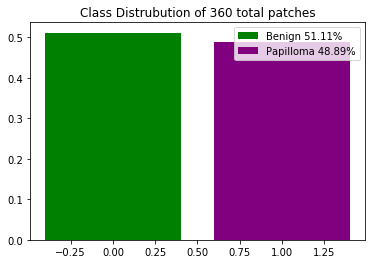

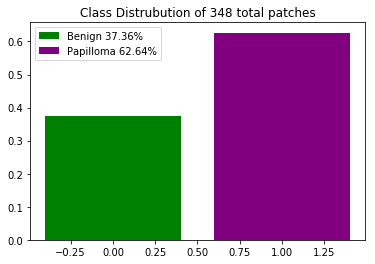

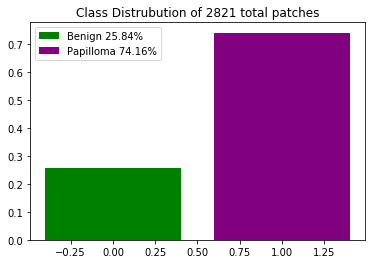

In [23]:
# BEFORE FILTERING PATCHES LOOK AT PATCH DISTRIBUTION
stats.plot_label_distribution(val_patches_df, labels=[1,2], label_key='label_id')
stats.plot_label_distribution(test_patches_df, labels=[1,2], label_key='label_id')
stats.plot_label_distribution(train_patches_df, labels=[1,2], label_key='label_id')

In [24]:
# FILTER PATCHES : some patches have way too much light or are just bad quality
#                  here we filter out patches which are so specular they contain very little information
#                  see: filtered patches are drawn onto the image at : ./exp_id/{train,test,val}/log/filter_highlight_patches - useful for debugging

train_dir = os.path.join(exp_id, 'train')
test_dir = os.path.join(exp_id, 'test')
val_dir = os.path.join(exp_id, 'val')

data_prep.filter_highlight_patches_for(train_dir, patch_size = 64, threshold=0.5)
data_prep.filter_highlight_patches_for(test_dir, patch_size = 64, threshold=0.5)
data_prep.filter_highlight_patches_for(val_dir, patch_size = 64, threshold=0.5)


bad patches: 9
before: 2821
cleaned: 2812
bad patches: 2
before: 348
cleaned: 346
bad patches: 0
before: 360
cleaned: 360


image_id contour_id  patch_id    patch_name    x    y  label_id
0    mdi-9abd4637   a587fb0a  86a39477  86a39477.jpg  934  333         2
1    mdi-9abd4637   a587fb0a  4d257de7  4d257de7.jpg  870  365         2
2    mdi-9abd4637   a587fb0a  83513676  83513676.jpg  902  365         2
3    mdi-9abd4637   a587fb0a  3a3554d9  3a3554d9.jpg  934  365         2
4    mdi-9abd4637   a587fb0a  a67b4947  a67b4947.jpg  966  365         2
5    mdi-9abd4637   a587fb0a  4be5e3c0  4be5e3c0.jpg  838  397         2
6    mdi-9abd4637   a587fb0a  0c559d3f  0c559d3f.jpg  870  397         2
7    mdi-9abd4637   a587fb0a  8b31b415  8b31b415.jpg  902  397         2
8    mdi-9abd4637   a587fb0a  9208a825  9208a825.jpg  934  397         2
9    mdi-9abd4637   a587fb0a  cdcf7451  cdcf7451.jpg  966  397         2
10   mdi-9abd4637   a587fb0a  811d76c9  811d76c9.jpg  806  429         2
11   mdi-9abd4637   a587fb0a  35979e5e  35979e5e.jpg  838  429         2
12   mdi-9abd4637   a587fb0a  a643a639  a643a639.jpg  870  429         2
13   mdi-9abd4637   a587fb0a  0cc3d5af  0cc3d5af.jpg  902  429         2
14   mdi-9abd4637   a587fb0a  1fcaa32c  1fcaa32c.jpg  934  429         2
15   mdi-9abd4637   a587fb0a  93f8c111  93f8c111.jpg  966  429         2
16   mdi-9abd4637   a587fb0a  a51772f5  a51772f5.jpg  806  461         2
17   mdi-9abd4637   a587fb0a  7c94f42d  7c94f42d.jpg  838  461         2
18   mdi-9abd4637   a587fb0a  29244d08  29244d08.jpg  870  461         2
19   mdi-9abd4637   a587fb0a  61de43d8  61de43d8.jpg  902  461         2
20   mdi-9abd4637   a587fb0a  b73df2c7  b73df2c7.jpg  934  461         2
21   mdi-9abd4637   a587fb0a  93bc13f4  93bc13f4.jpg  966  461         2
22   mdi-9abd4637   a587fb0a  b6fba03e  b6fba03e.jpg  806  493         2
23   mdi-9abd4637   a587fb0a  2aa7c65c  2aa7c65c.jpg  838  493         2
24   mdi-9abd4637   a587fb0a  6eec34e2  6eec34e2.jpg  870  493         2
25   mdi-9abd4637   a587fb0a  9c5ce8bc  9c5ce8bc.jpg  902  493         2
26   mdi-9abd4637   a587fb0a  09bd23ff  09bd23ff.jpg  934  493         2
27   mdi-9abd4637   a587fb0a  2ae6ff4e  2ae6ff4e.jpg  966  493         2
28   mdi-9abd4637   a587fb0a  78ae9d8d  78ae9d8d.jpg  806  525         2
29   mdi-9abd4637   a587fb0a  12fbf0f0  12fbf0f0.jpg  838  525         2
..            ...        ...       ...           ...  ...  ...       ...
330  mdi-5e3d3832   4963cf18  1dec112b  1dec112b.jpg  315  673         1
331  mdi-5e3d3832   4963cf18  442363c6  442363c6.jpg  347  673         1
332  mdi-5e3d3832   4963cf18  b0116c28  b0116c28.jpg  379  673         1
333  mdi-5e3d3832   4963cf18  911427ce  911427ce.jpg  411  673         1
334  mdi-5e3d3832   4963cf18  318b177e  318b177e.jpg  443  673         1
335  mdi-5e3d3832   4963cf18  2055e325  2055e325.jpg  475  673         1
336  mdi-5e3d3832   4963cf18  0c68f952  0c68f952.jpg  315  705         1
337  mdi-5e3d3832   4963cf18  6d39de65  6d39de65.jpg  347  705         1
338  mdi-5e3d3832   4963cf18  6bac279a  6bac279a.jpg  379  705         1
339  mdi-5e3d3832   4963cf18  80371243  80371243.jpg  411  705         1
340  mdi-5e3d3832   4963cf18  1be41f64  1be41f64.jpg  443  705         1
341  mdi-5e3d3832   4963cf18  e0eb1cd4  e0eb1cd4.jpg  475  705         1
342  mdi-5e3d3832   4963cf18  e1910dc7  e1910dc7.jpg  347  737         1
343  mdi-5e3d3832   4963cf18  ea4ce002  ea4ce002.jpg  379  737         1
344  mdi-5e3d3832   4963cf18  929f00ac  929f00ac.jpg  411  737         1
345  mdi-5e3d3832   4963cf18  bc97ea37  bc97ea37.jpg  443  737         1
346  mdi-5e3d3832   4963cf18  ec77fe1b  ec77fe1b.jpg  475  737         1
347  mdi-5e3d3832   4963cf18  8ed1c01f  8ed1c01f.jpg  347  769         1
348  mdi-5e3d3832   4963cf18  00099210  00099210.jpg  379  769         1
349  mdi-5e3d3832   4963cf18  6e0abb4e  6e0abb4e.jpg  411  769         1
350  mdi-5e3d3832   4963cf18  66c8ea10  66c8ea10.jpg  443  769         1
351  mdi-5e3d3832   4963cf18  23998dbe  23998dbe.jpg  475  769         1
352  mdi-5e3d3832   4963cf18  bc9a220f  bc9a220f.jpg  347  801     

In [25]:
## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

train_pdr = importing.PatchDataReader(os.path.join(train_dir, 'patches'), trainp_df)
test_pdr = importing.PatchDataReader(os.path.join(test_dir, 'patches'), testp_df)
val_pdr = importing.PatchDataReader(os.path.join(val_dir, 'patches'), valp_df)

train_img, train_labels = train_pdr.read_data()
test_img, test_labels = test_pdr.read_data()
val_img, val_labels = val_pdr.read_data()

display('train images: {}'.format(len(train_img)))
display('train labels: {}'.format(len(train_labels)))
display('test images: {}'.format(len(test_img)))
display('test labels: {}'.format(len(test_labels)))
display('val images: {}'.format(len(val_labels)))
display('val labels: {}'.format(len(val_img)))


'train images: 2812'

'train labels: 2812'

'test images: 346'

'test labels: 346'

'val images: 360'

'val labels: 360'

In [26]:
# CREATE SHUFFLED DATA

## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

idxs = data_prep.shuffle_indices(len(trainp_df))
shuffled_train_df = trainp_df.loc[idxs].reset_index(drop=True)
shuffled_train_df.to_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(testp_df))
shuffled_test_df = testp_df.loc[idxs].reset_index(drop=True)
shuffled_test_df.to_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(valp_df))
shuffled_val_df = valp_df.loc[idxs].reset_index(drop=True)
shuffled_val_df.to_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'), index=False)



In [27]:
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_pdr)
data_prep.log_patch_data_reader(test_dir, test_pdr)
data_prep.log_patch_data_reader(val_dir, val_pdr)